In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from pycocotools.coco import COCO
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

In [63]:
def sec2frame(seconds, fps):
    return round(seconds*fps)

def get_vid_meta(filename):
    video = cv2.VideoCapture(filename)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps

    return fps, duration, frame_count


def process_single(annot_fn, fps, fout, img_folder):
    with open(annot_fn) as f:
        contents = json.load(f)

    annot = contents['metadata']
    attr = contents['attribute']

    # not doing anything with the temporal 
    # section....... 
    obj_seg = []
    for d in annot.values():
        if len(d['z']) == 1:
            obj_seg.append(d)
    # just using object present & object id for this....
    name2i_attr = {d['aname']: i for i, d in attr.items()}
    object_present = name2i_attr['object_present']
    object_id = name2i_attr['object_id']
    object_label = name2i_attr['object_label']

    # coco starting out  
    coco_dict = { 'annotations': [ ]}

    # just gonna use object present & object id
    cat2id = {}
    id_count = 0
    dropped_items = []
    for i, obj in enumerate(obj_seg):
        av = obj['av']
        # ==2 checks for rectangle
        if (object_label not in av  and object_present not in av ) or obj['xy'][0] != 2:
            if len(dropped_items) == 0:
                dropped_items.append(name2i_attr)
            dropped_items.append(obj)
            continue 
        if av.get(object_label, None):
            cat = av[object_label].strip()
        else:
            cat = av[object_present].strip()

        c_id = av.get(object_id, '0').strip()
        # adding to categories.....if needed
        if (cat, c_id) not in cat2id:
                cat2id[(cat, c_id)] = id_count
                id_count +=1

        coco_dict['annotations'].append({
                'id': i,
                # we need keypoint or segmentation for some reason....
                'keypoints': None,
                'category_id': cat2id[(cat, c_id)],
                "image_id": sec2frame(obj['z'][0], fps),
                'bbox': obj['xy'][1:],
                'area': obj['xy'][-1]*obj['xy'][-2]

        })
            
            
            
    imgs = sorted(os.listdir(img_folder))
    paths = [f'{img_folder}/{f}' for f in imgs]
    assert(int(paths[-1].split('.jpg')[0].split('-')[-1]) == len(paths))
    coco_dict['images'] = [{'id':i, 'file_name':fn} for i, fn in enumerate(paths)]
    coco_dict['categories'] = [{'id': i, 'name': f'{cat}_{im}', 'supercategory':cat} 
                               for (cat, im), i in cat2id.items()]
    with open(fout, 'w') as f:
        json.dump(coco_dict, f)
    
    return dropped_items



In [64]:
frames = 'shark_frames'

prefixes = [f for f in os.listdir(frames) if os.path.isdir(f'{frames}/{f}')]

In [65]:
dropped_things = {}
d_folder ='data'
annot_folder = 'coco_files'
for p in prefixes:
    new_p = f'{d_folder}/{p}'
    if os.path.isfile(new_p + '.json') and os.path.isfile(new_p + '.mp4'):
        print(new_p)
        fps, _, _ = get_vid_meta(new_p + '.mp4')
        fout = f'{annot_folder}/{p}_coco.json'
        dropped_items = process_single(new_p+'.json', fps, fout, f'{frames}/{p}')
        if len(dropped_items) > 0:
            print(len(dropped_items))
            dropped_things[p] = dropped_items

data/20210910_SUPInteraction
data/20210403_SharkAndBodyboarders
2
data/20210910_SurferTowardsShark
data/20210401_ThreeSharksVeryCloseSurfers
data/2020731_JWSSeaLIonSUP
data/20210812_SharkOutsideLineUP
data/20210121_SharkNearTwoSurfers
data/20210121_SUPNexttoShark
7
data/20210615_SharkUnderSurfer
data/20210812_JamesWithShark2
data/20210401_ThreeSurfersTwoSharks
data/20200805_OneSharkSUPFollowsKids
data/20210910_SharkInsideLineUp_GreatInteraction
2
data/20210812_JamesWithShark3
data/20210910_SharkSwimmerSurfer
data/DJI_0386
data/20210812_JamesElizabethBrianWithShark
321
data/20210812_JamesWithShark
data/20200805_OneSharkSUPSurfers


In [72]:
for k, v in dropped_things.items():
    print(k, len(v))

20210403_SharkAndBodyboarders 2
20210121_SUPNexttoShark 7
20210910_SharkInsideLineUp_GreatInteraction 2
20210812_JamesElizabethBrianWithShark 321


In [74]:
dropped_things['20210812_JamesElizabethBrianWithShark']

[{'object_present': '1', 'object_id': '2', 'object_label': '3'},
 {'vid': '1',
  'flg': 0,
  'z': [0.002],
  'xy': [8,
   77.838,
   1271.351,
   71.351,
   1511.351,
   233.514,
   1511.351,
   252.973,
   1264.865],
  'av': {'1': 'human', '2': '0', '3': '1'}},
 {'vid': '1',
  'flg': 0,
  'z': [0.002],
  'xy': [8,
   227.027,
   888.649,
   220.541,
   1102.703,
   402.162,
   1102.703,
   408.649,
   895.135],
  'av': {'1': 'human', '2': '1', '3': '1'}},
 {'vid': '1',
  'flg': 0,
  'z': [0.002],
  'xy': [8,
   3314.595,
   45.405,
   3327.568,
   337.297,
   3587.027,
   343.784,
   3587.027,
   38.919],
  'av': {'1': 'human', '2': '2', '3': '1'}},
 {'vid': '1',
  'flg': 0,
  'z': [0.002],
  'xy': [8,
   2023.784,
   1232.432,
   2030.27,
   1459.459,
   2185.946,
   1472.432,
   2185.946,
   1245.405],
  'av': {'1': 'shark', '2': '0'}},
 {'vid': '1',
  'flg': 0,
  'z': [0.502],
  'xy': [8,
   51.892,
   1232.432,
   51.892,
   1524.324,
   259.459,
   1524.324,
   259.459,
   1232.4

In [10]:
def get_all_imgs_fldr(img_folder):
    imgs = sorted(os.listdir(img_folder))
    paths = [f'{img_folder}/{f}' for f in imgs]
    assert(int(paths[-1].split('.jpg')[0].split('-')[-1]) == len(paths))
    return paths

In [138]:
def generate_labeled_images(annFile, img_folder, box_thickness=10, output_folder='test', draw_text=True, 
                            fontScale = 4, color = (36,255,12), # neon green
                            font = cv2.FONT_HERSHEY_SIMPLEX, text_thickness = 10):
    # getting images & frames
    imgs = sorted(os.listdir(img_folder))
    paths = [f'{img_folder}/{f}' for f in imgs]
    assert(int(paths[-1].split('.jpg')[0].split('-')[-1]) == len(paths))
    frame_num = len(paths)
    
    # getting annotations 
    coco=COCO(annFile)
    cats = coco.loadCats(coco.getCatIds())
    nms=[cat['name'] for cat in cats]
    catIds = coco.getCatIds(catNms=nms);
    
    id2catname = {d['id']: d['name'] for d in coco.dataset['categories']}

    # some defaults 
    for i in range(frame_num):
        fn = paths[i]
        image = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
        annIds = coco.getAnnIds(imgIds=i, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        # adding annotations 
        for v in anns:
            rects = np.array(v['bbox']).astype(int)
            s = tuple(rects[:2])
            e = tuple(rects[:2] + rects[2:])
            image = cv2.rectangle(image, s, e, color, box_thickness)
            # drawing label id 
            if draw_text: 
                text = id2catname[v['category_id']]
                image = cv2.putText(image, img_folder, text, 
                                    fontScale, color, text_thickness, cv2.LINE_AA)
        if draw_text and i < 100:
            org = (50,150)
            text = img_folder.split('/')[-1]
            image = cv2.putText(image, text, org, font, 
                   fontScale, color, text_thickness, cv2.LINE_AA)
        
        out_fn = f'{output_folder}/{imgs[i]}'
        if len(anns) >0 and not cv2.imwrite(out_fn, image):
            print(out_fn)

In [60]:
def coco2mdNet(video_prefix, annFile, out_fldr= 'mdnet_input', frames_fldr=None, 
               future_frames_fldr='../../shared',
              results_folder=None):
    """
    # sample input file 
    {"seq_name": videoName_category, 
        "img_list": ["../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/
        20200805_OneSharkSUPFollowsKids-0001.jpg", 
        "init_bbox": [2005, 712, 44, 111], 
        "savefig_dir": "results/20200805_OneSharkSUPFollowsKids_humans", 
        "result_path": "results/20200805_OneSharkSUPFollowsKids_humans/results.json"}
    """
    if not results_folder:
        results_folder = f'results/{video_prefix}'
    
    if not frames_fldr:
        frames_fldr = f'shark_frames/{video_prefix}'
    
    img_paths = get_all_imgs_fldr(frames_fldr)
    img_paths = [f'{future_frames_fldr}/{f}' for f in img_paths]
    # just include the first one 
    coco=COCO(annFile)
    cats = coco.loadCats(coco.getCatIds())
    nms=[cat['name'] for cat in cats]
    
    extra_annots = {}
    for cat in nms:
        jsonf = {'seq_name': f'{video_prefix}_{cat}', 
                 'savefig_dir': f'{results_folder}_{cat}', 
                 'result_path': f'{results_folder}/results.json', 
                }
        # get coco info 
        catIds = coco.getCatIds(catNms=[cat])
        imgIds = coco.getImgIds(catIds=catIds)
        imgIds = sorted(imgIds)
        if len(imgIds) > 1:
            # load the first one 
            init_img_info = coco.loadImgs(imgIds[0])[0]
            fn = init_img_info['file_name']
            s_ind = init_img_info['id']

            #  get annotations
            annIds = coco.getAnnIds(imgIds=s_ind, catIds=catIds, iscrowd=None)
            anns = coco.loadAnns(annIds)
            if len(anns) > 1:
                print('\t', jsonf['seq_name'], len(anns))
                extra_annots[jsonf['seq_name']] = anns
            jsonf['init_bbox'] = anns[0]['bbox']
            jsonf['img_list'] = img_paths[s_ind:]

            with open(f'{out_fldr}/{video_prefix}_{cat}.json', 'w') as f:
                json.dump(jsonf, f)

In [61]:
annFldr ='coco_files'
for annFile in os.listdir(annFldr):
    if annFile.endswith('_coco.json'):
#         print(annFile)
        video_pre = annFile.split('_coco.json')[0]
        coco2mdNet(video_pre, f'{annFldr}/{annFile}')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
	 20210910_SharkInsideLineUp_GreatInteraction_human_0 12
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
	 20210812_JamesElizabethBrianWithShark_human_0 2
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
	 20210401_ThreeSharksVeryCloseSurfers_1_0 2
	 20210401_ThreeSharksVeryCloseSurfers_1_1 2
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creati

In [48]:
cat mdnet_input/20200805_OneSharkSUPFollowsKids_1_0.json

{"seq_name": "20200805_OneSharkSUPFollowsKids_1_0", "savefig_dir": "results/20200805_OneSharkSUPFollowsKids_1_0", "result_path": "results/20200805_OneSharkSUPFollowsKids_1_0/results.json", "init_bbox": [2011.829, 701.341, 62.561, 121.83], "img_list": ["../../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0002.jpg", "../../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0003.jpg", "../../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0004.jpg", "../../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0005.jpg", "../../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0006.jpg", "../../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0007.jpg", "../../../shared/shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0008.jpg", "../../../sha

In [139]:
annFile = 'coco_files/20200805_OneSharkSUPFollowsKids_coco.json'
# coco=COCO(annFile)
# cats = coco.loadCats(coco.getCatIds())
# nms=[cat['name'] for cat in cats]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [145]:
nms

['shark_0', '1_0', 'human_0', '1_00']

In [144]:
catIds = coco.getCatIds(catNms=['1_0'])
imgIds = coco.getImgIds(catIds=catIds);
coco.loadImgs(imgIds[0])

# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

[{'id': 1,
  'file_name': 'shark_frames/20200805_OneSharkSUPFollowsKids/20200805_OneSharkSUPFollowsKids-0002.jpg'}]

In [97]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
anns

[{'id': 639,
  'keypoints': None,
  'category_id': 1,
  'image_id': 217,
  'bbox': [2030.184, 713.99, 104.574, 86.544],
  'area': 9050.252256}]

[{'id': 0, 'name': 'shark_0', 'supercategory': 'shark'},
 {'id': 1, 'name': '1_0', 'supercategory': '1'},
 {'id': 2, 'name': 'human_0', 'supercategory': 'human'},
 {'id': 3, 'name': '1_00', 'supercategory': '1'}]

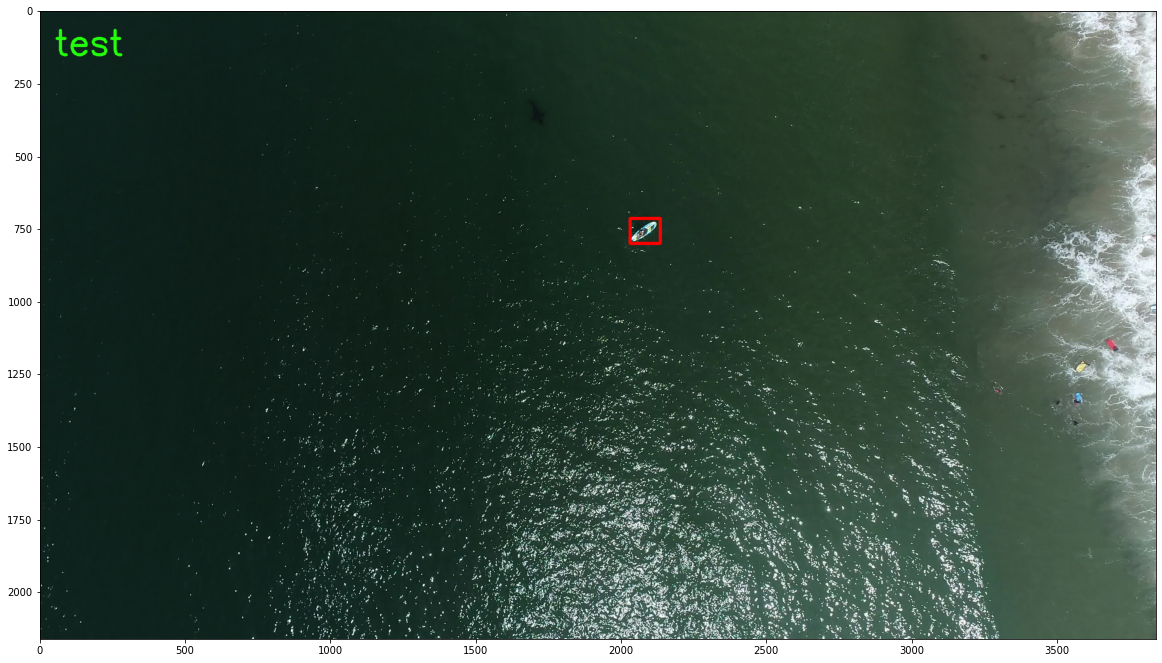

In [21]:
convert_imgs = set(prefixes) - set(dropped_things)

for pre in convert_imgs:
    annot_fn = f'{annot_folder}/{pre}_coco.json'
    frames_fn = f'{frames}/{pre}'
    print(pre)
    generate_labeled_images(annot_fn, frames_fn)
    

DJI_0386
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


KeyboardInterrupt: 

In [17]:
ls coco

20200805_OneSharkSUPFollowsKids/
20200805_OneSharkSUPSurfers/
2020731_JWSSeaLIonSUP/
20210121_SUPNexttoShark/
20210121_SharkNearTwoSurfers/
20210401_ThreeSharksVeryCloseSurfers/
20210401_ThreeSurfersTwoSharks/
20210403_SharkAndBodyboarders/
20210403_SharkApproachesSurfer/
20210615_SharkUnderSurfer/
20210812_JamesElizabethBrianWithShark/
20210812_JamesWithShark/
20210812_JamesWithShark2/
20210812_JamesWithShark3/
20210812_SharkOutsideLineUP/
20210910_SUPInteraction/
20210910_SharkInsideLineUp_GreatInteraction/
20210910_SharkSpeedingPastSurfers/
20210910_SharkSwimmerSurfer/
20210910_SurferTowardsShark/
DJI_0386/
via3_video_annotation_to_coco.html
via3_video_annotation_to_coco_new.html
via3_video_annotation_to_coco_single.html
